# Standalone Results Analysis

This notebook loads and visualizes results from saved logs without needing to run experiments.

In [1]:
import os
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import pandas as pd
from src.pruninghealing.logger import Logger

# Configuration
WORKSPACE = "../../workspace/iterative_debug"  # Change to your workspace

print(f"Loading logs from: {WORKSPACE}")

Loading logs from: ../../workspace/iterative_debug


In [2]:
# Load data from logs
log_analyzer = Logger(WORKSPACE)
log_analyzer.load_logs()
df = pd.DataFrame(log_analyzer.logs)

print(f"Loaded {len(df)} log entries")
print("\nLog structure:")
print(df.head())

Loaded 7 log entries

Log structure:
   step    action  layers_remaining  perplexity                   timestamp  \
0     0  baseline              32.0    10.90745  2025-07-27T14:53:21.901934   
1     1     prune               NaN         NaN  2025-07-27T14:54:23.993452   
2     1     train               NaN         NaN  2025-07-27T14:54:23.995507   
3     2     prune               NaN         NaN  2025-07-27T14:55:14.783037   
4     2     train               NaN         NaN  2025-07-27T14:55:14.784103   

   layer        ppl  
0    NaN        NaN  
1   17.0  12.589109  
2   17.0  11.442779  
3   18.0  12.878011  
4   18.0  11.480205  


Baseline perplexity: 10.907
Pruning steps: 3
Training steps: 3


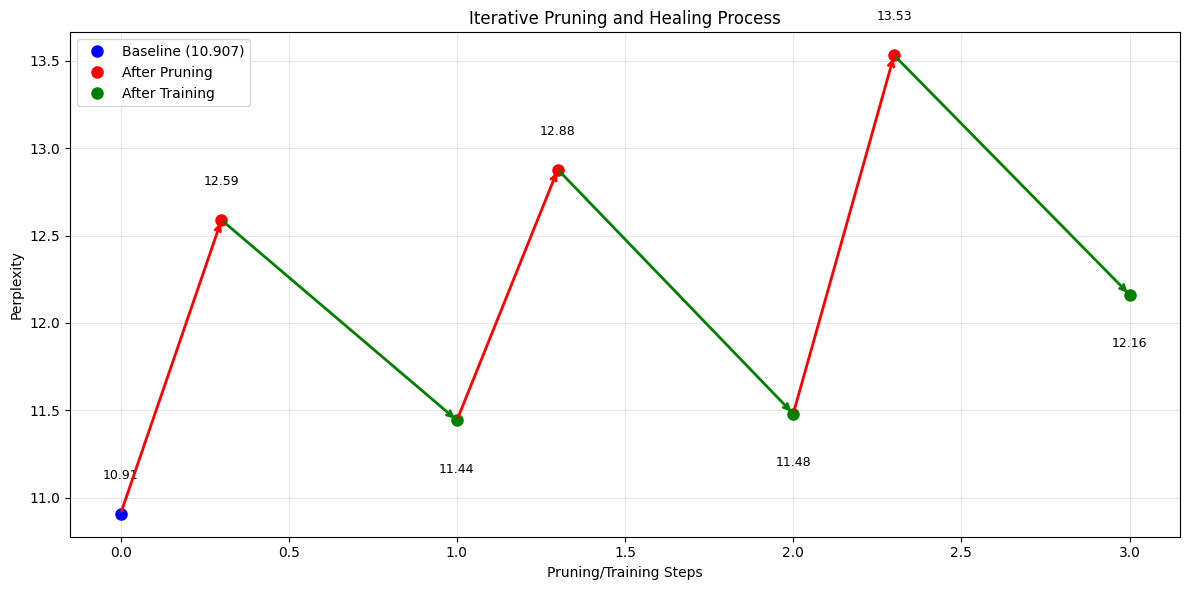

In [ ]:
if len(df) == 0:
    print("No logs found!")
else:
    # Получаем baseline
    baseline_data = df[df['action'] == 'baseline']
    if len(baseline_data) > 0:
        baseline_ppl = baseline_data.iloc[0]['perplexity']
    else:
        if len(df[df['action'] == 'prune']) > 0:
            baseline_ppl = df[df['action'] == 'prune'].iloc[0]['ppl']
        elif len(df[df['action'] == 'train']) > 0:
            baseline_ppl = df[df['action'] == 'train'].iloc[0]['ppl']
        else:
            baseline_ppl = 10.0

    prune_data = df[df['action'] == 'prune'].reset_index(drop=True)
    train_data = df[df['action'] == 'train'].reset_index(drop=True)

    print(f"Baseline perplexity: {baseline_ppl:.3f}")
    print(f"Pruning steps: {len(prune_data)}")
    print(f"Training steps: {len(train_data)}")

    if len(prune_data) > 0 and len(train_data) > 0:
        plt.figure(figsize=(12, 6))

        # Нарисовать baseline точку
        plt.plot(0, baseline_ppl, 'bo', markersize=8, label=f'Baseline ({baseline_ppl:.3f})')
        plt.text(0, baseline_ppl + 0.2, f'{baseline_ppl:.2f}', ha='center', fontsize=9)

        prev_x = 0
        prev_ppl = baseline_ppl

        for i in range(len(prune_data)):
            x_prune = i + 0.3
            x_train = i + 1
            prune_ppl = prune_data.iloc[i]['ppl']
            train_ppl = train_data.iloc[i]['ppl'] if i < len(train_data) else prune_ppl

            # Prune (стрелка вверх, точка)
            plt.annotate('', xy=(x_prune, prune_ppl), xytext=(prev_x, prev_ppl),
                         arrowprops=dict(arrowstyle='->', color='red', lw=2))
            plt.plot(x_prune, prune_ppl, 'ro', markersize=8, label='After Pruning' if i == 0 else '')
            plt.text(x_prune, prune_ppl + 0.2, f'{prune_ppl:.2f}', ha='center', fontsize=9)

            # Train (стрелка вниз, точка)
            plt.annotate('', xy=(x_train, train_ppl), xytext=(x_prune, prune_ppl),
                         arrowprops=dict(arrowstyle='->', color='green', lw=2))
            plt.plot(x_train, train_ppl, 'go', markersize=8, label='After Training' if i == 0 else '')
            plt.text(x_train, train_ppl - 0.3, f'{train_ppl:.2f}', ha='center', fontsize=9)

            prev_x = x_train
            prev_ppl = train_ppl

        plt.xlabel('Pruning/Training Steps')
        plt.ylabel('Perplexity')
        plt.title('Iterative Pruning and Healing Process')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No pruning/training data found in logs")

In [6]:
# Detailed analysis
print("\n=== DETAILED LOGS ===")
print(df)

if len(prune_data) > 0 and len(train_data) > 0:
    print("\n=== SUMMARY ===")
    print(f"Total pruning steps: {len(prune_data)}")
    print(f"Average degradation per prune: {(prune_data['ppl'].mean() - baseline_ppl):.3f}")
    print(f"Average recovery per train: {(prune_data['ppl'].mean() - train_data['ppl'].mean()):.3f}")
    print(f"Final perplexity: {train_data.iloc[-1]['ppl']:.3f}")
    print(f"Total change: {(train_data.iloc[-1]['ppl'] - baseline_ppl):+.3f}")


=== DETAILED LOGS ===
   step    action  layers_remaining  perplexity                   timestamp  \
0     0  baseline              32.0    10.90745  2025-07-27T14:53:21.901934   
1     1     prune               NaN         NaN  2025-07-27T14:54:23.993452   
2     1     train               NaN         NaN  2025-07-27T14:54:23.995507   
3     2     prune               NaN         NaN  2025-07-27T14:55:14.783037   
4     2     train               NaN         NaN  2025-07-27T14:55:14.784103   
5     3     prune               NaN         NaN  2025-07-27T14:55:47.551188   
6     3     train               NaN         NaN  2025-07-27T14:55:47.552521   

   layer        ppl  
0    NaN        NaN  
1   17.0  12.589109  
2   17.0  11.442779  
3   18.0  12.878011  
4   18.0  11.480205  
5   19.0  13.532174  
6   19.0  12.162145  

=== SUMMARY ===
Total pruning steps: 3
Average degradation per prune: 2.092
Average recovery per train: 1.305
Final perplexity: 12.162
Total change: +1.255
